In [460]:
# Import libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [120]:
# Import data
raw_data = pd.read_csv('data/raw.csv', sep = '|')

In [121]:
# clean column time
data_c = raw_data.copy()
data_c['time'] = data_c.time.str.replace('c', '')\
    .str.replace(':','')\
    .str.replace(';','')\
    .str.replace('Z','')\
    .str.replace('"','')\
    .str.replace('.','')\
    .str.replace('?', '0000')
data_c['time'] = data_c.time.str.strip()
data_c['time'] = np.where(data_c['time'].str.len() < 4, '0'+data_c['time'], data_c['time'])
data_c['time'] = np.where(data_c['time'].str.len() > 4, data_c['time'].str[:-1], data_c['time'])

# replace ? with NANs
data_nan = data_c.copy()
cols = ['cn_ln',
        'crew_aboard',
        'crew_fatalities',
        'date',
        'flight_no',
        'ground',
        'location',
        'operator',
        'passengers_aboard',
        'passengers_fatalities',
        'registration',
        'route',
        'summary',
        'total_aboard']

for col in cols:
    data_nan[col] = np.where(data_nan[col] == '?', np.nan, data_nan[col])

# remove leading and trailing white spaces
for col in ['ac_type', 'location', 'operator', 'route', 'summary']:
    data_nan[col] = data_nan[col].str.strip()

# format date-time
data_dt = data_nan.copy()
data_dt['dt'] = data_dt['date'] + ' ' + data_dt['time']
data_dt['dt'] = pd.to_datetime(data_dt['dt'], format='%B %d, %Y %H%M')
data_dt['year_date'] = data_dt['dt'].dt.to_period("Y")
data_dt['year_date'] = data_dt['year_date'].astype('str')

In [122]:
data_dt = data_dt[(data_dt['year_date'] != '2018') & (data_dt['year_date'] != '2019')]

In [123]:
data_grouped = pd.DataFrame(data_dt['dt'].groupby(data_dt['dt'].dt.to_period("Y")).agg('count'))
data_grouped.rename(columns = {'dt': 'count'}, inplace = True)
data_grouped = data_grouped.reset_index().rename(columns = {'dt': 'year_date'})
data_grouped['year_date'] = data_grouped['year_date'].astype('str')

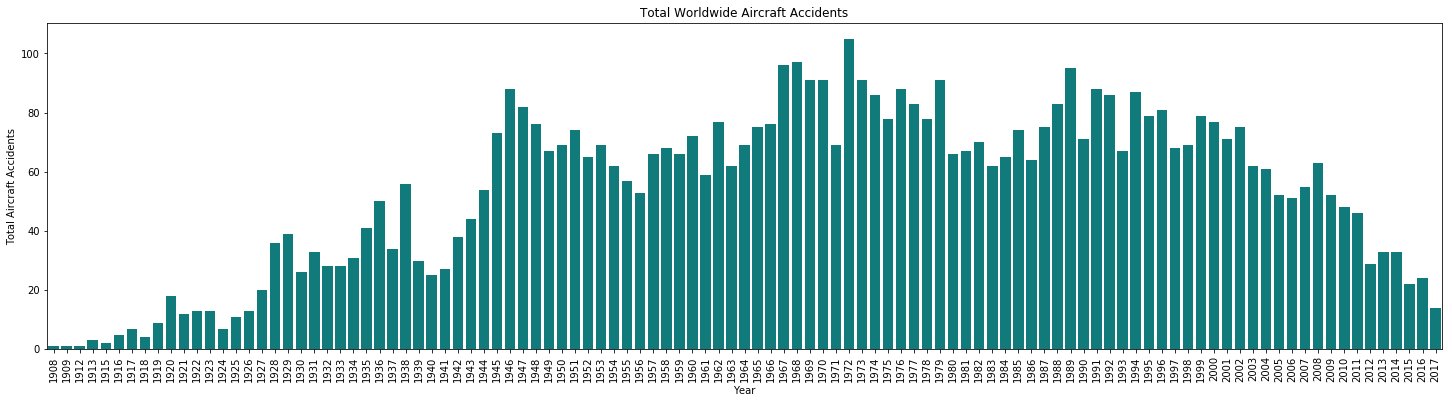

In [124]:
plt.figure(figsize=(25, 6))
g = sns.barplot(x="year_date", y="count", data=data_grouped, color="darkcyan");
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_title('Total Worldwide Aircraft Accidents');
g.set(xlabel='Year', ylabel='Total Aircraft Accidents');

In [134]:
raw_flight_history = pd.read_csv('data/API_IS.AIR.DPRT_DS2_en_csv_v2_6211.csv')
raw_flight_history.drop(['2018', 'Unnamed: 63'], axis = 1, inplace = True)

In [135]:
total_flights = raw_flight_history[raw_flight_history['Country Name'] == 'World']
total_flights = pd.DataFrame(total_flights.select_dtypes(pd.np.number).sum().rename('total'))
total_flights = total_flights.reset_index().rename(columns = {'index': 'year_date'})
total_flights['year_date'] = total_flights['year_date'].astype('str')

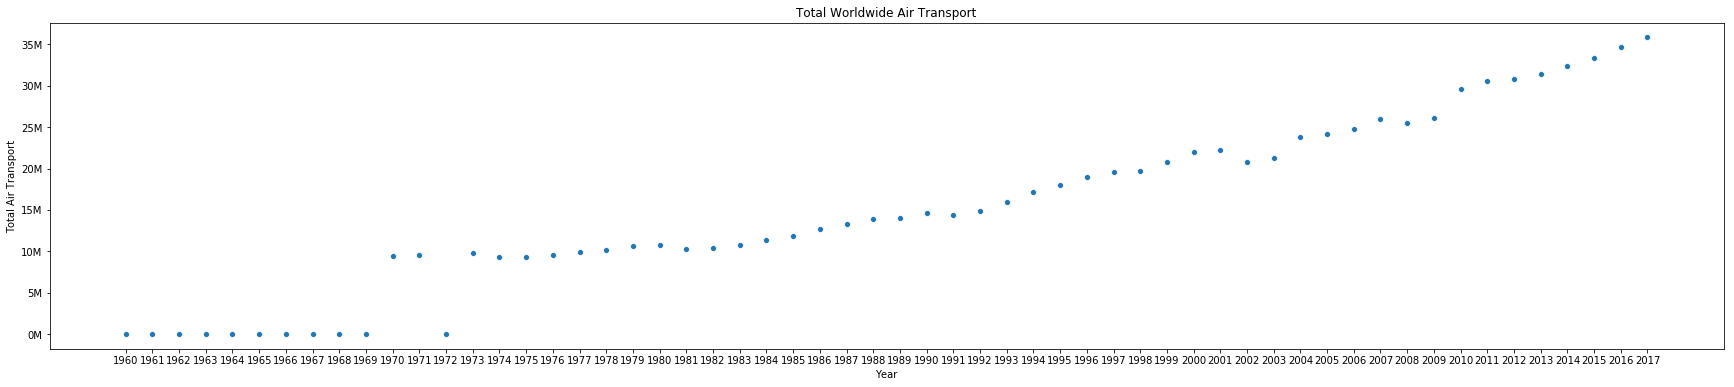

In [136]:
plt.figure(figsize=(30, 6))
g = sns.scatterplot(x="year_date", y="total", data=total_flights)
ylabels = ['{:,.0f}'.format(x) + 'M' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);
g.set_title('Total Worldwide Air Transport');
g.set(xlabel='Year', ylabel='Total Air Transport');

In [482]:
flight_data = pd.merge(data_grouped, total_flights, on='year_date', how='inner')
flight_data['year_date'] = flight_data['year_date'].astype('int')

In [483]:
flight_data = flight_data[flight_data['year_date'] >= 1973].reset_index(drop=True)

In [484]:
flight_data['failure_perc'] = flight_data['count']/flight_data['total']

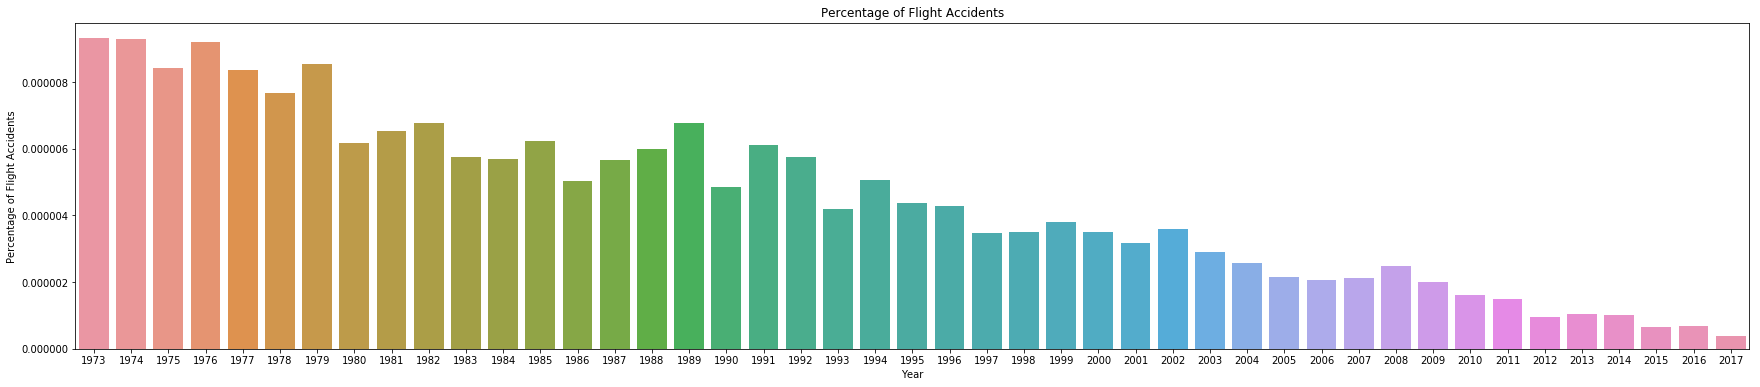

In [485]:
plt.figure(figsize=(30, 6))
g = sns.barplot(x="year_date", y="failure_perc", data=flight_data)
g.set_title('Percentage of Flight Accidents');
g.set(xlabel='Year', ylabel='Percentage of Flight Accidents');

In [486]:
X = flight_data['year_date'].values
Y = flight_data['failure_perc'].values
ln_Y = np.log(Y)
regr = linear_model.LinearRegression()
X = np.reshape(X, (X.size, 1))
regr.fit(X,ln_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [487]:
model = LinearRegression()

In [488]:
temp = flight_data[flight_data['year_date'] >= 1995].reset_index(drop=True)
x = temp['year_date'].values.reshape(-1, 1)
y = temp['total'].values
model.fit(x, y)
y_pred = model.predict([[2018], [2019]])

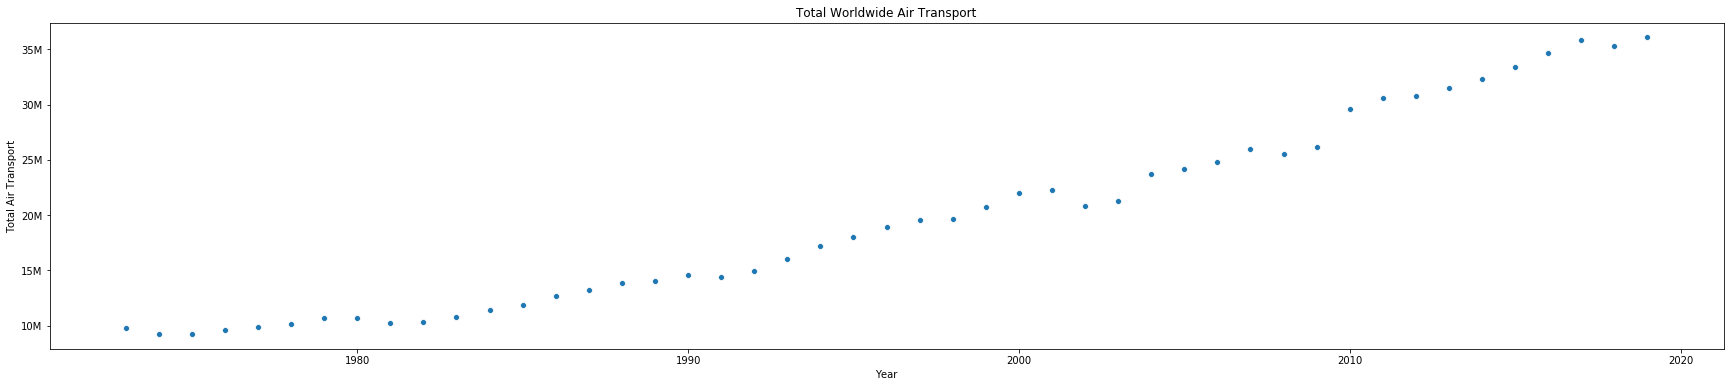

In [489]:
flight_data.loc[len(flight_data)+1] = [2018, y_pred[0]*np.exp(regr.coef_*2018 + regr.intercept_), y_pred[0], np.exp(regr.coef_*2018 + regr.intercept_)]
flight_data.loc[len(flight_data)+1] = [2019, y_pred[1]*np.exp(regr.coef_*2019 + regr.intercept_), y_pred[1], np.exp(regr.coef_*2019 + regr.intercept_)]
plt.figure(figsize=(30, 6))
g = sns.scatterplot(x="year_date", y="total", data=flight_data)
ylabels = ['{:,.0f}'.format(x) + 'M' for x in g.get_yticks()/1000000]
g.set_yticklabels(ylabels);
g.set_title('Total Worldwide Air Transport');
g.set(xlabel='Year', ylabel='Total Air Transport');

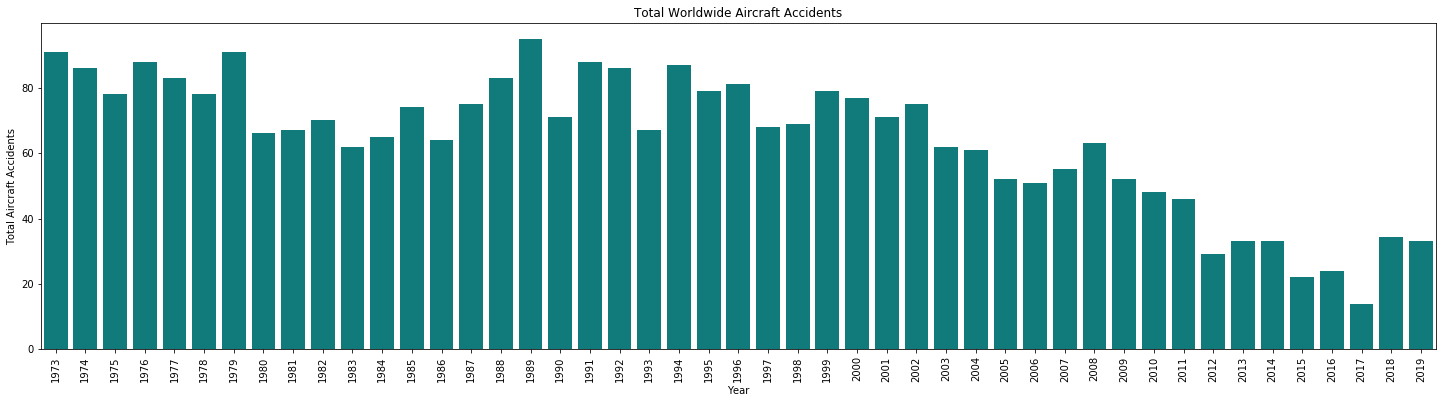

In [490]:
plt.figure(figsize=(25, 6))
g = sns.barplot(x="year_date", y="count", data=flight_data, color="darkcyan");
g.set_xticklabels(g.get_xticklabels(),rotation=90);
g.set_title('Total Worldwide Aircraft Accidents');
g.set(xlabel='Year', ylabel='Total Aircraft Accidents');

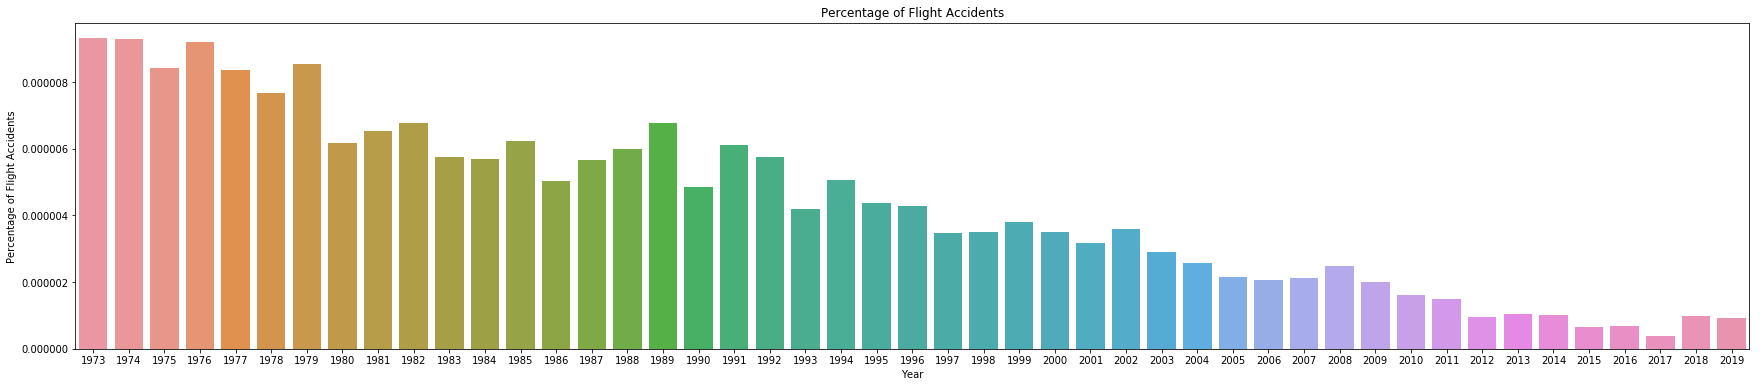

In [491]:
plt.figure(figsize=(30, 6))
g = sns.barplot(x="year_date", y="failure_perc", data=flight_data)
g.set_title('Percentage of Flight Accidents');
g.set(xlabel='Year', ylabel='Percentage of Flight Accidents');

In [399]:
x = flight_data['year_date'].values
y = flight_data['failure_perc'].values
model_fit = np.polyfit(np.log(x), y, 1)

In [400]:
model_fit

array([-0.00038548,  0.00293347])

In [401]:
model_fit[0]*np.log(2019) + model_fit[1]

-1.4396252656471986e-07

In [434]:
flight_data.loc[len(flight_data)+1] = [2019, 'x', 'x', np.exp(regr.coef_*2018 + regr.intercept_)]

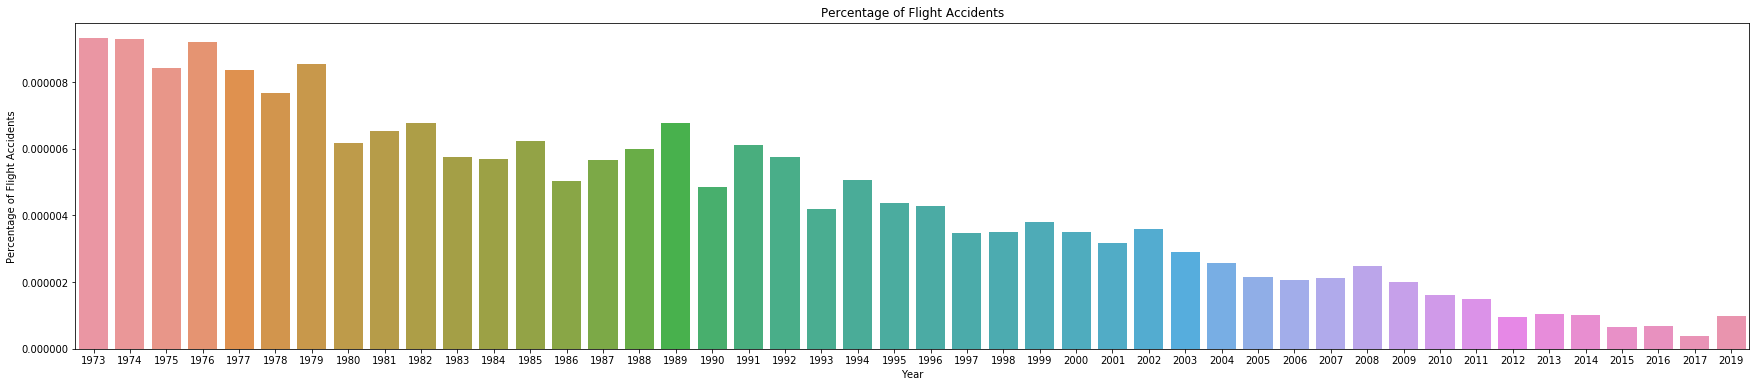

In [435]:
plt.figure(figsize=(30, 6))
g = sns.barplot(x="year_date", y="failure_perc", data=flight_data)
g.set_title('Percentage of Flight Accidents');
g.set(xlabel='Year', ylabel='Percentage of Flight Accidents');

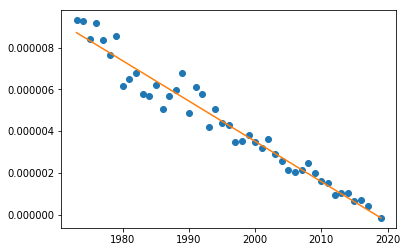

In [419]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
import numpy as np
from scipy.optimize import curve_fit



x = flight_data['year_date'].values
y = flight_data['failure_perc'].values

def exponenial_func(x, a, b, c):
    return a*np.exp(-b*x)+c


popt, pcov = curve_fit(exponenial_func, x, y, p0=(1, 1e-6, 1))

xx = np.arange(1973,2020)
yy = exponenial_func(xx, *popt)

plt.plot(x,y,'o', xx, yy)


In [420]:
yy

array([ 8.72339382e-06,  8.53024806e-06,  8.33710246e-06,  8.14395700e-06,
        7.95081170e-06,  7.75766655e-06,  7.56452156e-06,  7.37137671e-06,
        7.17823202e-06,  6.98508748e-06,  6.79194310e-06,  6.59879886e-06,
        6.40565478e-06,  6.21251086e-06,  6.01936708e-06,  5.82622346e-06,
        5.63307999e-06,  5.43993667e-06,  5.24679351e-06,  5.05365050e-06,
        4.86050764e-06,  4.66736493e-06,  4.47422238e-06,  4.28107998e-06,
        4.08793773e-06,  3.89479563e-06,  3.70165369e-06,  3.50851190e-06,
        3.31537026e-06,  3.12222878e-06,  2.92908744e-06,  2.73594626e-06,
        2.54280524e-06,  2.34966436e-06,  2.15652364e-06,  1.96338307e-06,
        1.77024265e-06,  1.57710239e-06,  1.38396228e-06,  1.19082232e-06,
        9.97682512e-07,  8.04542859e-07,  6.11403358e-07,  4.18264009e-07,
        2.25124814e-07,  3.19857710e-08, -1.61153119e-07])

array([1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017])

In [412]:
np.linspace(1973, 2018, 1)

array([1973.])

In [413]:
np.linspace(300, 6000, 1000)

array([ 300.        ,  305.70570571,  311.41141141,  317.11711712,
        322.82282282,  328.52852853,  334.23423423,  339.93993994,
        345.64564565,  351.35135135,  357.05705706,  362.76276276,
        368.46846847,  374.17417417,  379.87987988,  385.58558559,
        391.29129129,  396.996997  ,  402.7027027 ,  408.40840841,
        414.11411411,  419.81981982,  425.52552553,  431.23123123,
        436.93693694,  442.64264264,  448.34834835,  454.05405405,
        459.75975976,  465.46546547,  471.17117117,  476.87687688,
        482.58258258,  488.28828829,  493.99399399,  499.6996997 ,
        505.40540541,  511.11111111,  516.81681682,  522.52252252,
        528.22822823,  533.93393393,  539.63963964,  545.34534535,
        551.05105105,  556.75675676,  562.46246246,  568.16816817,
        573.87387387,  579.57957958,  585.28528529,  590.99099099,
        596.6966967 ,  602.4024024 ,  608.10810811,  613.81381381,
        619.51951952,  625.22522523,  630.93093093,  636.63663

In [244]:
flight_data.head()

,year_date,count,total,failure_perc
13,1973,91,9764900.0,0.000009
14,1974,86,9254900.0,0.000009
15,1975,78,9244700.0,0.000008
16,1976,88,9562900.0,0.000009
17,1977,83,9915900.0,0.000008


In [266]:
from sklearn.ensemble import RandomForestRegressor

In [269]:
model = RandomForestRegressor(random_state=1, n_estimators=100)

In [270]:
model.fit(flight_data['year_date'].values.reshape(-1, 1), flight_data['failure_perc'].values)
y_pred = model.predict([[2018], [2019]])
print(y_pred)

[4.36724614e-06 4.36724614e-06]


In [271]:
flight_data.loc[len(flight_data)+1] = [2018, 'x', 'x', y_pred[0]]

In [259]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [260]:
model.fit(flight_data['year_date'].values.reshape(-1, 1), flight_data['failure_perc'].values)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [261]:
print('coefficient of determination:', model.score(flight_data['year_date'].values.reshape(-1, 1) , flight_data['failure_perc'].values))

coefficient of determination: 0.9540363085692021


In [262]:
y_pred = model.predict([[2018], [2019]])
print(y_pred)

[ 3.03382886e-08 -1.62857993e-07]


array([ 3.03382886e-08, -1.62857993e-07])

In [169]:
np.array([2019, 2020]).reshape((-1, 1))

array([[2019],
       [2020]])

In [181]:
np.array([2019, 2020])

array([2019, 2020])

In [189]:
flight_data['year_date'].values.reshape(1,-1)

array([[1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
        1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
        1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
        2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
        2017]])

In [201]:
flight_data['failure_perc'].values

array([9.31909185e-06, 9.29237485e-06, 8.43726676e-06, 9.20222945e-06,
       8.37039502e-06, 7.65929868e-06, 8.54187396e-06, 6.16540089e-06,
       6.52379237e-06, 6.77257687e-06, 5.76277803e-06, 5.69975447e-06,
       6.21958497e-06, 5.04851306e-06, 5.66259966e-06, 5.97943937e-06,
       6.77550264e-06, 4.86838226e-06, 6.12774965e-06, 5.76453870e-06,
       4.19111484e-06, 5.05258756e-06, 4.38689042e-06, 4.27359446e-06,
       3.47886589e-06, 3.51087864e-06, 3.80968915e-06, 3.49862313e-06,
       3.18897316e-06, 3.60275729e-06, 2.91317557e-06, 2.56813818e-06,
       2.14736614e-06, 2.05401802e-06, 2.11408275e-06, 2.47077301e-06,
       1.99061936e-06, 1.61954633e-06, 1.50499045e-06, 9.42434031e-07,
       1.04880440e-06, 1.02041504e-06, 6.59416304e-07, 6.91882617e-07,
       3.90594452e-07])

In [202]:
np.array([5, 20, 14, 32, 22, 38])

array([ 5, 20, 14, 32, 22, 38])

In [206]:
flight_data['year_date'].values.reshape(1,-1)

array([[1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
        1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
        1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
        2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
        2017]])

In [207]:
np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))

array([[ 5],
       [15],
       [25],
       [35],
       [45],
       [55]])

In [216]:
flight_data['year_date'].values.reshape(-1, 1)

array([[1973],
       [1974],
       [1975],
       [1976],
       [1977],
       [1978],
       [1979],
       [1980],
       [1981],
       [1982],
       [1983],
       [1984],
       [1985],
       [1986],
       [1987],
       [1988],
       [1989],
       [1990],
       [1991],
       [1992],
       [1993],
       [1994],
       [1995],
       [1996],
       [1997],
       [1998],
       [1999],
       [2000],
       [2001],
       [2002],
       [2003],
       [2004],
       [2005],
       [2006],
       [2007],
       [2008],
       [2009],
       [2010],
       [2011],
       [2012],
       [2013],
       [2014],
       [2015],
       [2016],
       [2017]])

In [438]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model

# # create some exponential data
# X = np.arange(1, 10, 0.1)
# print(X)
# Y = np.power(2, X)
# print(Y)


X = flight_data['year_date'].values
Y = flight_data['failure_perc'].values

# transform the exponential Y data to make it a straight line
ln_Y = np.log(Y)

# show the exponential plot
plt.scatter(X, Y)
plt.show()

# Create linear regression object
regr = linear_model.LinearRegression()

# reshape the X to avoid regr.fit errors
X = np.reshape(X, (X.size, 1))

# Train the model using the training sets
regr.fit(X,ln_Y)

# The coefficients
print('Slope: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)

# predict Y when X = 1.1 (should be approximately 2.14354693)
# equation = e^(0.00632309*1.1) + 2.7772517886
print("predicted val = ", np.exp(regr.coef_*2018 + regr.intercept_))

AttributeError: 'float' object has no attribute 'log'

In [432]:
regr.coef_

array([-0.05620681])

In [ ]:
np.exp(regr.coef_*2018 + regr.intercept_)